### Clustring with Gaussian Mixtures Model: EM Algorithm

In [1]:
import numpy as np
from scipy.stats import multivariate_normal

In [2]:
#Log likelihood: used for EM steps evalutions
#pi: clusters weights
#mu: means
#sigma: covariace matrices
#k: number of clusters
def log_sum_exp(Z):
    """ Compute log(\sum_i exp(Z_i)) for some array Z."""
    return np.max(Z) + np.log(np.sum(np.exp(Z - np.max(Z))))

def loglikelihood(data, weights, means, covs):
    """ Compute the loglikelihood of the data for a Gaussian mixture model with the given parameters."""
    num_clusters = len(means)
    num_dim = len(data[0])
    
    ll = 0
    for d in data:
        
        Z = np.zeros(num_clusters)
        for k in range(num_clusters):
            # Compute (x-mu)^T * Sigma^{-1} * (x-mu)
            delta = np.array(d) - means[k]
            exponent_term = np.dot(delta.T, np.dot(np.linalg.inv(covs[k]), delta))
            # Compute loglikelihood contribution for this data point and this cluster
            Z[k] += np.log(weights[k])
            Z[k] -= 1/2. * (num_dim * np.log(2*np.pi) + np.log(np.linalg.det(covs[k])) + exponent_term)
            
        # Increment loglikelihood contribution of this data point across all clusters
        ll += log_sum_exp(Z)
        
    return ll 

In [3]:
def compute_responsabilities(data, pi, mu, sigma):
    num_clusters = len(mu)
    d = len(data)
    r = np.zeros((d,num_clusters))
    
    for i in range(d):    
        temp = 0
        for k in range(num_clusters):
            temp += pi[k] * multivariate_normal.pdf(data[i], mu[k], sigma[k])
        
        for k in range(num_clusters):
            r[i,k] = (pi[k] * multivariate_normal.pdf(data[i],mu[k],sigma[k]))/temp
        
    return r

In [4]:
#The sum of all responsibilities for each cluster:
def count_sum_responsability_weight(resp):
    return np.sum(resp, axis=0)

In [5]:
#The weight of the clusters:
#K: number of clusters
def pi_updates(counts):
    num_data = np.sum(counts)
    K = len(counts)
    pi = np.zeros(K)
    for k in range(K):
        pi[k] = counts[k]/num_data
    return pi

In [6]:
#Means updates:
def mu_updates(data, resp, counts):
    K = len(counts)
    d = (data.shape)[1]
    l = (data.shape)[0]
    mu_new = np.zeros((K,d))
    
    for k in range(K):
        temp = 0
        for i in range(l):
            temp += resp[i,k]*data[i]
        mu_new[k] = temp/counts[k]
    
    return mu_new

In [7]:
#Covariance Matrix updates:
def sigma_updates(data, mu, resp, counts):
    K = len(counts)
    d = (data.shape)[1]
    l = (data.shape)[0]
    sigma_new = np.zeros((K,d,d))
    
    for k in range(K):
        temp = np.zeros((d,d))
        for i in range(l):
            u = data[i] - mu[k]
            temp += resp[i,k]*(np.outer(u,u))
        sigma_new[k] = temp/counts[k]
    
    return sigma_new

In [8]:
def EM_Mixtures_Gaussian(data, init_pi, init_mu, init_sigma, maxiter=100, thresh=1e-4):
    
    pi = init_pi[:]
    mu = init_mu[:]
    sigma = init_sigma[:]
    
    loglik = loglikelihood(data, pi, mu, sigma)
    loglik_list = [loglikelihood]
    
    for itr in range(maxiter):
    
        #E-step: compute responsibilities
        resp = compute_responsabilities(data, pi, mu, sigma)
    
        #M-step
        #Compute the total responsibility for each cluster
        counts = count_sum_responsability_weight(resp)
        #Update the weight for cluster k 
        pi = pi_updates(counts)
        #Update means
        mu = mu_updates(data, resp, counts)
        #Update covariances
        sigma = sigma_updates(data, mu, resp, counts)
        # The loglikelihood
        curr_loglik = loglikelihood(data, pi, mu, sigma)
        loglik_list.append(curr_loglik)
        
        if(curr_loglik - loglik < thresh):
            break
        
        loglik = curr_loglik
        
        #if(itr%5 == 0):
        print("Iteration {}, the loglikelihood: {}".format(itr, loglik))
    
    results = {'weights': pi, "means": mu, "covs": sigma, "resp": resp, "loglikelihood_trace": loglik_list}
    return results

### Test the model with isotropic Gaussian blobs:

In [9]:
from sklearn.datasets.samples_generator import make_blobs

In [13]:
# Generate sample data
means = [[1, 1], [-1, -1], [1, -1]]
X, labels_true = make_blobs(n_samples=750, centers=means, cluster_std=0.4,
                            random_state=0)

In [14]:
test_data = X

In [15]:
means = np.array(means)

In [16]:
#init
init_weights = [1/3, 1/3, 1/3]
cov = np.diag([test_data[:,0].var(), test_data[:,1].var()])
init_covs = [cov, cov, cov]

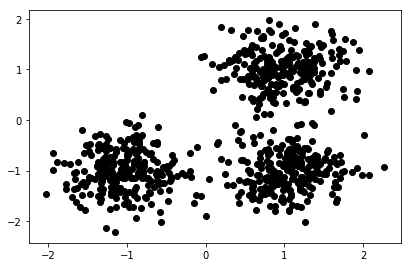

In [18]:
#### plot data point:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
for i in range(len(X)):
    plt.plot(X[i,0], X[i,1], 'o', c='black')
plt.rcParams.update({'font.size':16})
plt.tight_layout()

In [20]:
#Helper:
import colorsys

def plot_responsibilities_in_RB(img, resp, title):
    N, K = resp.shape
    
    HSV_tuples = [(x*1.0/K, 0.5, 0.9) for x in range(K)]
    
    RGB_tuples = []
    for x in HSV_tuples:
        RGB_tuples.append(colorsys.hsv_to_rgb(*x))

    R = img[:,0]
    B = img[:,1]
    resp_by_img_int = [[resp[n][k] for k in range(K)] for n in range(N)]
    cols = [tuple(np.dot(resp_by_img_int[n], np.array(RGB_tuples))) for n in range(N)]
    
    plt.figure()
    for n in range(len(R)):
        plt.plot(R[n], B[n], 'o', c=cols[n])
    plt.title(title)
    plt.xlabel('R value')
    plt.ylabel('B value')
    plt.rcParams.update({'font.size':16})
    plt.tight_layout()

Iteration 0, the loglikelihood: -1830.740125483854
Iteration 1, the loglikelihood: -1685.422063577508
Iteration 2, the loglikelihood: -1550.9734527236178
Iteration 3, the loglikelihood: -1528.07149513364
Iteration 4, the loglikelihood: -1527.4969521384774


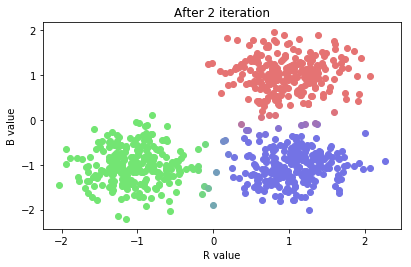

In [21]:
#plot after learning responsabilities:
test_results = EM_Mixtures_Gaussian(test_data, init_weights, means, init_covs, maxiter=5, thresh=1e-4)
plot_responsibilities_in_RB(test_data, test_results['resp'], 'After 2 iteration')

### Test: Images data

In [22]:
from PIL import Image
import os
root = './images/'
list_folders = ['cloudy_sky', 'rivers', 'sunsets', 'trees_and_forest']
folders_sizes = []
data = []

read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))

for folder_name in list_folders:
    name = root + folder_name
    ims = [read(os.path.join(name, filename)) for filename in os.listdir(name)]
    #im_array = np.array(ims)
    folders_sizes.append(len(ims))
    data = data + ims

data = np.array(data)

In [23]:
#We will represente image with a 3-dimensional vector [r, g, b] where r: is the average value of red pixels...
img_data = []

for i in range(len(data)):
    arr = data[i]
    r = np.mean(arr[:,:,0]/256.0)
    g = np.mean(arr[:,:,1]/256.0)
    b = np.mean(arr[:,:,2]/256.0)
    x  = [r, g, b]
    img_data.append(x)

img_data = np.array(img_data)

In [24]:
img_data[0].shape

(3,)

### Initialization:

In [25]:
np.random.seed(0)

k = 4
init_pi = [1/4, 1/4, 1/4, 1/4]
init_mu = [img_data[e]  for e in np.random.choice(len(img_data), k, replace=False)]

In [26]:
covariance_matrix = np.diag([img_data[:,0].var(), img_data[:,1].var(), img_data[:,2].var()])
init_sigma = [covariance_matrix, covariance_matrix, covariance_matrix, covariance_matrix]

In [27]:
#Run our EM algorithm on the image data using the above initializations.
results = EM_Mixtures_Gaussian(img_data, init_pi, init_mu, init_sigma, maxiter=2, thresh=1e-4)

Iteration 0, the loglikelihood: 3132.0692172145878
Iteration 1, the loglikelihood: 3243.706162729131


In [28]:
results

{'weights': array([0.30901748, 0.17967642, 0.31775611, 0.19354999]),
 'means': array([[0.47522951, 0.38101166, 0.29972793],
        [0.31566248, 0.31429741, 0.27283547],
        [0.38800745, 0.42271918, 0.39795799],
        [0.53881329, 0.59265048, 0.62812295]]),
 'covs': array([[[ 0.01491795,  0.00141864, -0.00298677],
         [ 0.00141864,  0.01225999,  0.00999492],
         [-0.00298677,  0.00999492,  0.02165877]],
 
        [[ 0.00733103,  0.00334458,  0.00344877],
         [ 0.00334458,  0.00850909,  0.00643013],
         [ 0.00344877,  0.00643013,  0.01329565]],
 
        [[ 0.00642993,  0.00384777,  0.00305563],
         [ 0.00384777,  0.00656824,  0.00620645],
         [ 0.00305563,  0.00620645,  0.01602886]],
 
        [[ 0.01105324,  0.00676084,  0.00334729],
         [ 0.00676084,  0.00923827,  0.01012121],
         [ 0.00334729,  0.01012121,  0.01869176]]]),
 'resp': array([[1.15806350e-01, 7.21802113e-03, 2.21478632e-01, 6.55496997e-01],
        [1.86737341e-02, 1.6691212

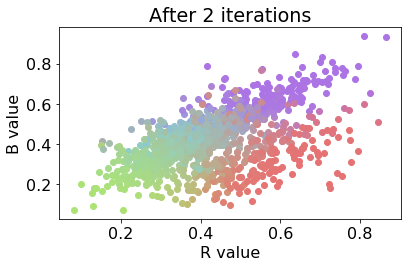

In [31]:
plot_responsibilities_in_RB(img_data, results['resp'], 'After 2 iterations')